# Classification with SVM on the D-Wave Advantage Quantum Annealer

#### This notebook performs the evaluation and visualization of the results returned from the quantum annealer. The results have to be obtained with another script (e.g. submit_experiments.sh).

The classification map that is reported in the paper is the one obtained with the following parameters:

- B = 3
- K = 2
- gamma = -1
- xi = 5
- E = 0
- embedding 2
- annealing time = 100
- rel. chain strength = 0.5
- Energy -45.506845443310596 

On test data
- Overal accuracy 0.873516
- F1 score 0.7344402173456618


## Import Packages

In [1]:
# load_ext autoreload
#autoreload 2
import numpy as np
import glob
from utils import *
import matplotlib.pyplot as plt
from matplotlib import colors
from sklearn import preprocessing

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from quantum_SVM import *   # QA SVM

## Load the training and test sets

X_train (100, 8)
Y_train (100,)
X_test (250000, 8)
Y_test (250000,)


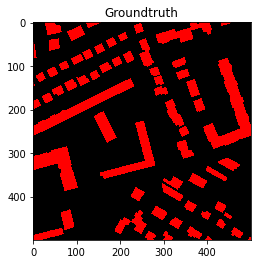

In [2]:
# Load training set
key='_tiny'
X_train=np.load('data/X_train_tile_4'+key+'.npy')
Y_train=np.load('data/Y_train_tile_4'+key+'.npy')

print('X_train',X_train.shape) 
print('Y_train',Y_train.shape) 

# Load test set
X_test=np.load('data/X_test_tile_8_subregion.npy')
Y_test=np.load('data/Y_test_tile_8_subregion.npy')

print('X_test',X_test.shape) 
print('Y_test',Y_test.shape) 

# for training, the labels have to be -1,+1; i.e., replace 0 -> -1
Y_train=np.where(Y_train==0,-1,Y_train)

groundtruth=np.reshape(Y_test,(500,500))
plt.title('Groundtruth')
cmap = colors.ListedColormap(['black', 'red'])
plt.rcParams["figure.figsize"] = (5,5)
view=plt.imshow(groundtruth,cmap=cmap)

## QSVM

### Parameters

In [3]:
outputpath='output/run_calibtrain'+key
maxalphas=20 # the 20 lowest-energy results returned by the quantum annealer are stored, but for the evaluation, we can consider less and compare

# Parameters 
Bs=[2,3] #[2,3,5,10]                      Base
Ks=[2] #[2,3]                             Number of qubits
xis=[0,1,5] #[0,1,5]                      Strength to consider the constraint
gammas=[-1] #[-1,0.125,0.25,0.5,1,2,4,8]  Kernel
Es=[0,1,2] #[0,1,2]                       Exponent
annealing_times=[1,10,100]
chain_strengths=[0.2,0.5,1,2,5]
embeddings=[0,1,2,3]


In [15]:
# generate qubos and couplers (embeddings)
# make sure you have signed up in dwavesys.com and registered your computer 'dwave config create' with profile (login) and api key
for B in Bs:
    for K in Ks:
        for gamma in gammas:
            for xi in xis:
                for E in Es:
                    subpath=f"_B={B}_K={K}_xi={xi}_E={E}_gamma={float(gamma)}"
                    path = outputpath+subpath+"/"
                    gen_svm_qubos(X_train,Y_train,B,K,xi,gamma,E,path)
                    dwave_run_embedding(X_train,Y_train,path,annealing_times,chain_strengths,embeddings,solver={'qpu': True}) #solver='Advantage_system1.1' 

Extracting nodes and couplers
Saving 200 nodes and 19900 couplers for output/run_calibtrain_tiny_B=2_K=2_xi=0_E=0_gamma=-1.0/
running output/run_calibtrain_tiny_B=2_K=2_xi=0_E=0_gamma=-1.0/result_couplers=7500/ with 200 nodes and 7500 couplers for embedding [0, 1, 2, 3]


TypeError: 'BinaryQuadraticModel' object is not iterable

### Evaluation

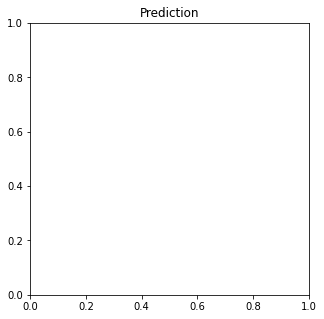

In [8]:
cmap = colors.ListedColormap(['black', 'red'])
plt.title('Prediction')
plt.rcParams["figure.figsize"] = (5,5)
Y_train_bin=np.where(Y_train==-1,0,Y_train)

for B in Bs:
    for K in Ks:
        for gamma in gammas:
            for xi in xis:
                for E in Es:
                    dirs=glob.glob(outputpath+f'_B={B}_K={K}_xi={xi}_E={E}_gamma={gamma}/result_couplers=*')
                    if not dirs:
                        dirs=glob.glob(outputpath+f'_B={B}_K={K}_xi={xi}_E={E}_gamma={float(gamma)}/result_couplers=*')
                    if len(dirs) == 0:
                        break
                    path=dirs[0]+'/'
                    f = open(path+f'collected_data_all_embeddings_maxalphas{maxalphas}.txt',"w") 
                    f.write("#rcs \tt_a \t trainacc\t trainF1score\t testacc\t testF1score\t average energy(train)\n") 
                    for emb in embeddings:
                        for c in chain_strengths:
                            for t in annealing_times:
                                alphas=np.load(path+f'embedding{emb}_rcs{c}_ta{t}_alphas.npy')
                                if not maxalphas == 0 or maxalphas > len(alphas):
                                    alphas = alphas[0:maxalphas]

                                scores_train=predict(X_train,X_train,Y_train,alphas,path)
                                Y_predict_train=np.sign(scores_train)
                                Y_predict_train=np.where(Y_predict_train==-1,0,Y_predict_train)
                                Y_predict_train=np.where(Y_predict_train==1,1,Y_predict_train)

                                scores=predict(X_test,X_train,Y_train,alphas,path)
                                Y_predict=np.sign(scores)
                                Y_predict=np.where(Y_predict==-1,0,Y_predict)   # From -1 to 0
                                Y_predict=np.where(Y_predict==1,1,Y_predict)    # From -1 to 1
        
                                trainacc = accuracy_score(Y_train_bin[:], Y_predict_train)
                                trainF1score = f1_score(Y_train_bin[:], Y_predict_train)
                                testacc = accuracy_score(Y_test[:], Y_predict)
                                testF1score = f1_score(Y_test[:], Y_predict)
                                alphas_avg = np.mean(alphas,axis=0)
                                av_energy = compute_energy(alphas_avg,X_train,Y_train,gamma,xi)
                
                                f.write(f'{c:1.2f}\t {t:4}\t {trainacc:8.4f}\t{trainF1score:8.4f}\t{testacc:8.4f}\t{testF1score:8.4f}\t{av_energy:8.4f}')
                                f.write("\n")

                                #  Visualize the prediction only for reasonable solutions
                                if testacc > 0.75 and testF1score > 0.7: 
                                    print(f'B = {B}, K = {K}, gamma = {gamma}, xi = {xi}, E = {E},\n  embedding {emb}, annealing time = {t}, rel. chain strength = {c}')
                                    #print('On train data:')
                                    #print ('Overal accuracy',trainacc)
                                    #print ('F1 score',trainF1score)
                                    print('Energy',av_energy)
                                    print('On test data')
                                    print ('Overal accuracy',testacc)
                                    print ('F1 score',testF1score)
                                    classification_map=np.reshape(Y_predict,(500,500))
                                    plt.imshow(classification_map, cmap=cmap)
                                    plt.clim(0, 1)
                                    plt.show()
                
                            f.write("\n")
                        f.write("\n")
                    f.close()
        